# Tutorial 9 (Observer)

This is a tutorial for E-Cell4. Here, we explain Observer classes for logging various types of data during simulation.

In [1]:
from ecell4.core import *
from ecell4 import gillespie

m = NetworkModel()
m.add_reaction_rule(create_unimolecular_reaction_rule(Species("A"), Species("B"), 1.0))
m.add_reaction_rule(create_unimolecular_reaction_rule(Species("B"), Species("A"), 0.5))

w = gillespie.GillespieWorld(Real3(1, 1, 1))
w.add_molecules(Species("A"), 60)

s = gillespie.GillespieSimulator(m, w)
s.initialize()

Prepare observers. Not necessarily needed to be created here.

In [2]:
obs1 = FixedIntervalNumberObserver(1.0, ["A"])
obs2 = NumberObserver(["A", "B"])
obs3 = TimingNumberObserver([0, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1], ["A"])
obs4 = FixedIntervalHDF5Observer(5.0, "test%02d.h5")

Run simulation with observers. **Warning: HDF5 is not supported as a default.** ``World::save`` raises NotSupported error without the HDF5 feature.

In [3]:
s.run(16.0, [obs1, obs2, obs3])
# s.run(16.0, [obs1, obs2, obs3, obs4])

NumberObservers return data by calling the member function `NumberObserver::data()`. `NumberObserver::targets()` returns a list of species, which you specified as an argument of the constructor.

In [4]:
print(obs1.data())
print([sp.serial() for sp in obs1.targets()])

[[0.0, 60.0], [1.0, 35.0], [2.0, 24.0], [3.0, 19.0], [4.0, 22.0], [5.0, 17.0], [6.0, 19.0], [7.0, 19.0], [8.0, 25.0], [9.0, 17.0], [10.0, 16.0], [11.0, 20.0], [12.0, 26.0], [13.0, 28.0], [14.0, 22.0], [15.0, 23.0], [16.0, 20.0]]
[u'A']


The normal `NumberObserver` stores the numbers of given `Species` just after every steps. It doesn't work properly with `ODESimulator` because `ODESimulator` has no internal `dt`. `FixedIntervalNumberObserver` logs them with the fixed step interval. `TimingNumberObserver` allow you to give the times of logging as an argument of the constructor.

In [5]:
print(obs2.data()[: 5])
print(obs3.data())

[[0.0, 60.0, 0.0], [0.0005296620982938665, 59.0, 1.0], [0.025797171507728964, 58.0, 2.0], [0.03127863998992734, 57.0, 3.0], [0.03380828016652807, 56.0, 4.0]]
[[0.0, 60.0], [0.001, 59.0], [0.01, 59.0], [0.1, 54.0], [1.0, 35.0], [10.0, 16.0]]


`FixedIntervalHDF5Observer` saves a `World` in the HDF5 format. `FixedIntervalHDF5Observer::filename()` returns the name of a file scheduled to be saved next. At most one format string like `%02d` is allowed to use a step count in the file name. When you do not use the format string, it overwrites the latest data to the file.

In [6]:
print(obs4.filename())

test00.h5


`viz.plot_number_observer` is the easiest way to plot a result in the `NumberObserver`, `FixedIntervalNumberObserver` and `TimingNumberObserver`. For the detailed usage of `viz.plot_number_observer`, see `help(viz.plot_number_observer)`.

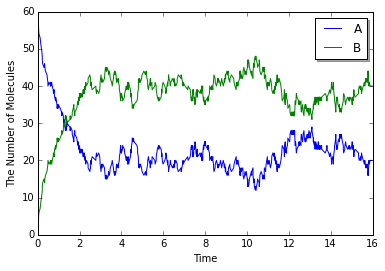

In [7]:
%matplotlib inline
from ecell4 import viz
viz.plot_number_observer(obs2)

Of course, you can analyze and plot the results by yourself.

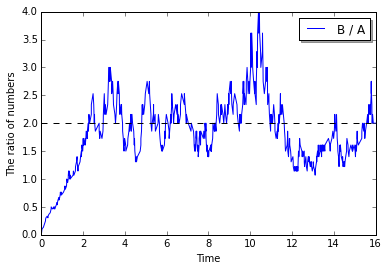

In [8]:
%matplotlib inline
import numpy
import matplotlib.pylab as plt

labels = [sp.serial() for sp in obs2.targets()]
data = numpy.asarray(obs2.data()).T

plt.plot(data[0], data[2] / data[1], label="{1} / {0}".format(labels[0], labels[1]))
plt.plot([data[0][0], data[0][-1]], [2.0, 2.0], 'k--')
plt.xlabel("Time")
plt.ylabel("The ratio of numbers")
plt.legend(loc="best", shadow=True)
plt.show()

**Warning: HDF5 is not supported as a default.** Check HDF5 files.

In [9]:
# import glob
# print(glob.glob("test*.h5"))
# w.load('test03.h5')
# print(w.t(), w.num_molecules(Species("A")), w.num_molecules(Species("B")))

For logging positions of particles, `FixedIntervalHDF5Observer`, `FixedIntervalCSVObserver` and `FixedIntervalTrajectoryObserver` are available. Here is an example with the `spatiocyte` module.

In [10]:
from ecell4 import spatiocyte

m = NetworkModel()
m.add_species_attribute(Species("A", "0.005", "1"))

w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1), 0.005)
w.bind_to(m)
w.add_molecules(Species("A"), 3)

s = spatiocyte.SpatiocyteSimulator(w)
s.initialize()

The usage of `FixedIntervalCSVObserver` is almost same with that of `FixedIntervalHDF5Observer`. It saves positions (x, y, z) of particles with the radius (r) and serial number of `Species` (sid). `FixedIntervalTrajectoryObserver` keeps tracking of particles, which you specified with `ParticleID`s. Once some `ParticleID` is lost for the reaction, it just stop to trace the particle any more.

In [11]:
obs5 = FixedIntervalCSVObserver(0.3, "test%02d.csv")
obs6 = FixedIntervalTrajectoryObserver(1e-3, [pid for pid, p in w.list_particles()])

The way to run a simulation with these `Observer`s is the same with the above for `NumberObserver`s.

In [12]:
s.run(1.0, [obs5, obs6])

Chek CSV files.

In [13]:
import glob
print(glob.glob("test*.csv"))
print(open("test00.csv").read())

['test00.csv', 'test03.csv', 'test02.csv', 'test01.csv']
x,y,z,r,sid
0.93080610225760774,0.24248711305964282,0.56000000000000005,0.0050000000000000001,0
0.20412414523193154,0.82561088494116486,0.94000000000000006,0.0050000000000000001,0
0.58787753826796285,0.12990381056766581,0.875,0.0050000000000000001,0



Generally, `World` assumes a periodic boundary for each plane. To avoid the big jump of a particle at the edge because of the boundary condition, `FixedIntervalTrajectoryObserver` tries to keep the shift of positions. Thus, the positions stored in the `Observer` are not necessarily limited in the cuboid given for the `World`. Of course, you can disable this option. See `help(FixedIntervalTrajectoryObserver)`.

In [14]:
print([tuple(pos) for pos in obs6.data()[0][: 5]])
print([tuple(pos) for pos in obs6.data()[0][-5:]])

[(0.9308061022576077, 0.24248711305964282, 0.56), (0.9797958971132713, 0.1905255888325765, 0.46), (0.9961258287318259, 0.15588457268119896, 0.42), (0.9716309313039941, 0.17609183210283585, 0.425), (0.938971068066885, 0.21939310229205777, 0.48)]
[(0.718516991216399, 0.3204293994002423, 0.995), (0.7920016834998943, 0.2800148805569685, 1.0150000000000001), (0.7430118886442307, 0.3406366588218792, 0.96), (0.718516991216399, 0.4243524478543749, 0.9550000000000001), (0.751176854453508, 0.37239092362730863, 0.9550000000000001)]


A user can easily plot the trajectory of particles by using `viz.plot_trajectory`. For the detailed usage, see [the Visualizer section](Visualizer.ipynb) and `help(viz.plot_trajectory)`. 

In [15]:
# _ = viz.plot_trajectory(obs6)